# SIT796: Reinforcement Learning
**Task 3.1D: Exact Policy Iteration Implementation for MDPs**

---
- Name: Bree McLennan  
- Student ID: 400150369  
---

**Overview** 

During week 3, you have learnt about Markov Decision Processes. You have also been provided with an example of the implementation of Value Iteration in the workshop for the week. 

In this task you need to implement the exact policy iteration method and test it in the environment you scoped in Task 1.1P. Your implementation should employ a linear system to find the exact solution for a policy that can achieve the goal. Your report, on the other hand, should refer to the relevant pseudocode in your Jupyter Notebook. You are also expected to show a graphical model similar to that used in Week 3 Practical corresponding to your state and transition probabilities. Also include the average reward result over 1000 steps. 

To complete this assignment, you need to refer back to Week 1 lecture, Task 1.1P and Practical 3.

**Submission Details**

For this task you need to provide the code and a report on the implementation of the exact policy iteration that allows you to achieve the goal. You may use Practical 3 as the basis for the demonstration of your policy, but the environment itself has to be that you scoped in Task 1.1P. The implementation of the policy iteration method should be from scratch. To solve the actual linear system you may use NumPy. 

The policy iteration should be demonstrated using a Jupiter notebook. The report and the Jupiter notebook need to be submitted to OnTrack. To do so, Convert the Jupyter Notebook to a PDF and append it to your report so as to submit that document. Also include a URL link to a GitHub repo containing the Notebook file and the environment implementation. You may have to install pandoc to convert a Jupyter Notebook to a PDF document: 
http://pandoc.org/installing.html



# 1. The CartPole game

As described in Task 1.1P, The Cart-Pole environment comprises of a pole stick with an un-actuated joint attached to a cart. It resembles an inverted pendulum with its centre of gravity above its pivot point. This cart-pole vehicle moves freely along a frictionless horizontal, one-dimensional track. The pole can move only rotationally on the vertical plane, relative to the cart and all movements of the cart and the pole are constrained by the laws of physics. The goal of this task is to prevent the pole from falling over by keeping the cart-pole balanced vertically by applying appropriate left (-1) and right (+1) forces to the pivot point. The episode ends when the pole reaches more than 15 degrees from vertical, or the cart moves horizontally more than 2.4 units from the centre of the environment.


This python notebook aims to solve the CartPole game using a simple linear approach and conclude with exploring the Markov Decision Process (MDP) for the CartPole game.

# 2. Environment Setup and Configuration

In [7]:
# install required system dependencies
!{sys.executable} -m pip install gym #Install the gym environment
!pip install gym[box2d,atari] pyvirtualdisplay
!apt-get install -y xvfb x11-utils 
!apt-get install x11-utils > /dev/null 2>&1
!pip install PyVirtualDisplay==2.0.* \
  PyOpenGL==3.1.* \
  PyOpenGL-accelerate==3.1.* \
  gym[box2d]==0.17.* 
!pip install pyglet
!pip install mdp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
x11-utils is already the newest version (7.7+5).
xvfb is already the newest version (2:1.20.13-1ubuntu1~20.04.8).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
#Import key libraries to run the CartPole environment
import gym
import numpy as np
import matplotlib.pyplot as plt
import cv2 #For plotting the MDP and exporting to .png image file
import time #for timings

#Libraries with useful helper functions
import sys
import pandas as pd
import random
import IPython
import base64
import io
import os
import pyvirtualdisplay

#Suppress any future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#For animating and visualising the solutions to the CartPole environment
from IPython import display
from IPython.display import HTML
from pyvirtualdisplay import Display

#For MDP library, functions and visualisation
from google.colab import drive

In [9]:
#Start the Display capture for the solution
display = Display(visible=0, size=(1400, 900))
display.start()

# 3. Initialise the CartPole Environment

To solve the cartpole balancing problem, the environment needs to be initialized. The CartPole environment has an:

**Observation or state space** which defines the structure of information received from the environment. In this context it will be
1. The position of the cart on the horizontal track. Positive value means 'right' position.
2. The cart's horizontal velocity. Positive means moving to the right.
3. The angle of the pole on the vertical axis. Positive means clock-wise.
4. The rate of rotation change (angular velocity) of the pole angle. Positive means rotating clock-wise.

These states will be technically represented as a 4-dimensional state such as x=(theta, y, theta_dot, y_dot). Where 'theta' is the angle of the pole, 'y' the position of the cart and 'theta_dot' & 'y_dot' are their respective velocities.

**Action space** that defines possible actions. In this context the actions are two discrete actions: left (0) and right (1). 

In [11]:
#Setup the display capture to visually record the solution.
done = Display(visible=0, size=(1024, 768))
done.start()
os.environ["DISPLAY"] = ":" + str(display.display)

#Initialise the CartPole version 0 environment
env = gym.make('CartPole-v0')
observation_space = env.observation_space
env.seed(123)  #Set a seed for repeatability

[123]

# 4. Set Parameters

Here the number of iterations 'episodes' is defined. This will be set to 1000 to adequately capture the performance on the solution policy.

In [12]:
# Define the number of episodes (steps) to run
num_episodes = 1000

# Create the bounds for each state variable
state_bounds = list(zip(env.observation_space.low, env.observation_space.high))
state_bounds[1] = [-0.5, 0.5]
state_bounds[3] = [-np.radians(50), np.radians(50)]

# Create the number of states to discretize into
num_states = (10, 10, 10, 10)

In [13]:
# Define parameters: learning rate, discount factor, exploration rate
learning_rate = 0.1
discount_factor = 0.99
exploration_rate = 0.5

In [14]:
# Initialize the Q-table with zeros
q_table = np.zeros(num_states + (env.action_space.n,))

In [15]:
# Define a function to discretize a state
def discretize_state(state):
    #Use bounds to define the boundaries of the observation space
    bounds = list(zip(observation_space.low, observation_space.high))
    #use the state and bounds to create the discretized state
    discretized_state = tuple(int(np.digitize(s, np.linspace(b[0], b[1], num=10))) for s, b in zip(state, bounds))
    return discretized_state

In [16]:
# Create a function to run an episode of the cart-pole-v0 problem
# This function is used to run a looped series of episodes on CartPole-v0 environment,
# It will use the Q-table that has been trained by the Q-learning algorithm. 
# This function uses an exploration rate (epsilon) as input, 
# which determines how often the agent should take a random action 
# instead of the action suggested by the Q-table

def run_episode(exploration_rate):
    #reset the environment state and initialise total reward to 0
    state = env.reset()
    done = False
    total_reward = 0
    #While cart pole is still active and episode is not finished
    while not done:
        #select an action using the epsilon-greedy strategy based
        # on the Q-table values for the current state
        state_discrete = discretize_state(state)
        if np.random.random() < exploration_rate:
            action = env.action_space.sample()
        else:
            action = np.argmax(q_table[state_discrete])

        next_state, reward, done, _ = env.step(action)
        #reward is added to the total reward for the episode
        total_reward += reward
        next_state_discrete = discretize_state(next_state)

        # Update the Q-table using the Bellman Expectation equation
        # using the state, action, reward, and next state information
        q_table[state_discrete + (action,)] += learning_rate * (reward + discount_factor * np.max(q_table[next_state_discrete]) - q_table[state_discrete + (action,)])

        state = next_state

    return total_reward

# 5. Testing a Policy to Solve CartPole
The Q-learning algorithm is applied to learn the optimal action-value function, represented by the Q-table. It uses the Bellman Expectation equation to calculate the value of a environment state by taking the weighted sum of the expected returns for each action, where the weights are the probabilities of taking each action in the given state. In this solution, the state is discretized using a simple rounding method, and the weights are calculated based on the softmax function applied to the Q-values for each action.

In [18]:
# Initialize a list to store the rewards from each episode
episode_rewards = []

# Run the episodes
for episode in range(num_episodes):
    exploration_rate *= 0.99
    total_reward = run_episode(exploration_rate)
    print(f"Episode {episode+1}/{num_episodes} - Total Reward: {total_reward}")
    episode_rewards.append(total_reward)

# Calculate the average reward over the episodes
average_reward = sum(episode_rewards) / num_episodes

env.close()
env.reset() #Close and reset the environment.

Episode 1/1000 - Total Reward: 65.0
Episode 2/1000 - Total Reward: 14.0
Episode 3/1000 - Total Reward: 28.0
Episode 4/1000 - Total Reward: 28.0
Episode 5/1000 - Total Reward: 59.0
Episode 6/1000 - Total Reward: 59.0
Episode 7/1000 - Total Reward: 64.0
Episode 8/1000 - Total Reward: 16.0
Episode 9/1000 - Total Reward: 15.0
Episode 10/1000 - Total Reward: 90.0
Episode 11/1000 - Total Reward: 50.0
Episode 12/1000 - Total Reward: 13.0
Episode 13/1000 - Total Reward: 33.0
Episode 14/1000 - Total Reward: 54.0
Episode 15/1000 - Total Reward: 12.0
Episode 16/1000 - Total Reward: 46.0
Episode 17/1000 - Total Reward: 41.0
Episode 18/1000 - Total Reward: 22.0
Episode 19/1000 - Total Reward: 10.0
Episode 20/1000 - Total Reward: 15.0
Episode 21/1000 - Total Reward: 16.0
Episode 22/1000 - Total Reward: 45.0
Episode 23/1000 - Total Reward: 39.0
Episode 24/1000 - Total Reward: 49.0
Episode 25/1000 - Total Reward: 71.0
Episode 26/1000 - Total Reward: 34.0
Episode 27/1000 - Total Reward: 25.0
Episode 28

array([-0.03557435,  0.03185821, -0.01266796,  0.04845947])

**Visualise the results of testing the policy**

The average reward for each episode is shown below, calculated over 1000 iterations.

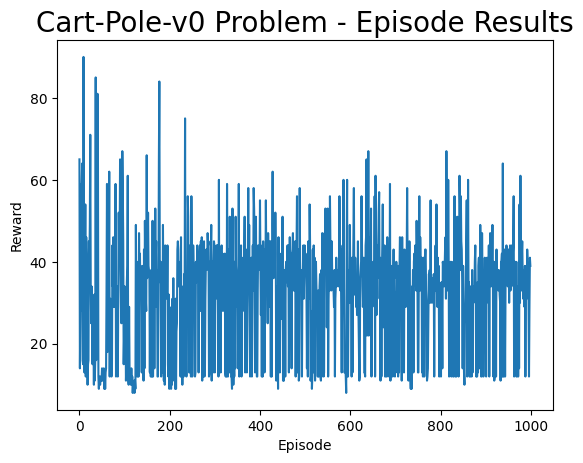

In [19]:
# Plot the rewards over the episodes
plt.plot(episode_rewards)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Cart-Pole-v0 Problem - Episode Results', fontsize=20)
plt.show()

#6. Markov Decision Process (MDP)

In [ ]:
# state names for use in building a MDP
states = [
      'Theta',
      'y',
      'theta_dot',
      'y_dot'
    ]  
# action names for use in building a MDP
actions = ['Left','Right']
# Define the known discrete mdp environment
# Define our transition probabilities with respect to stochasticity
transition_probs = {
        'Theta': {
            'Left': { 'Theta': 0.7, 'y': 0.3},
            'Right': { 'theta_dot': 0.9, 'y_dot': 0.1}
        },
        'y': {
            'Left': { 'Theta': 0.2, 'y': 0.8},
            'Right': { 'y_dot': 0.7, 'theta_dot': 0.3}
        },
        'theta_dot': {
            'Left': { 'theta_dot': 0.9, 'y_dot': 0.1},
            'Right': { 'Theta': 0.9, 'y': 0.1}
        },
        'y_dot': {
            'Left': { 'y_dot': 0.7, 'theta_dot': 0.3 },
            'Right': { 'y': 0.6, 'Theta': 0.4 }
        }
    }
# Define the rewards
rewards = {
        'Theta': {
            'Left': { 'Theta': +1, 'y': 0},
            'Right': { 'theta_dot': +1, 'y_dot': 0}
        },
        'y': {
            'Left': { 'Theta': +1, 'y': 0},
            'Right': { 'y_dot': +1, 'theta_dot': 0}
        },
        'theta_dot': {
            'Left': { 'theta_dot': +1, 'y_dot': 0},
            'Right': { 'Theta': +1, 'y': 0}
        },
        'y_dot': {
            'Left': { 'y_dot': +1, 'theta_dot': 0},
            'Right': { 'y': +1, 'Theta': 0}
        }
    }

In [ ]:
#Code reused from SIT796 Week 3 Workshop.
from google.colab import drive
drive.mount('/content/drive')
sys.path.insert(0,'/content/drive/MyDrive/Uni Assignments/SIT796 Reinforcement Learning/Task 3')

from mdp import has_graphviz
# if we dont have graphvizualization support
# then we don't need to run this cell
if has_graphviz:

  from mdp import MDP
  from mdp import plot_graph, plot_graph_with_state_values, plot_graph_optimal_strategy_and_state_values
  mdp = MDP(transition_probs, rewards, initial_state='Theta')

Mounted at /content/drive


In [ ]:
#Visualise the markov chain graph for CartPole
graph = plot_graph(mdp)
# Save as svg file
graph.format = 'png'
graph.view(filename='SIT796_Task3_1D_MDP', directory='./')

'SIT796_Task3_1D_MDP.png'

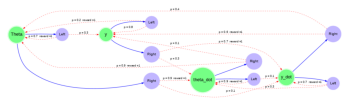

In [ ]:
#plot the markov chain visual here
MDP_plot = cv2.imread('SIT796_Task3_1D_MDP.png',1)
plt.imshow(MDP_plot)
plt.axis("off")
plt.show()

# References

This notebook borrows the ideas of the following authors and their contributions:

[1] J. Furby (2019) CartPole-v0 [Source Code] https://github.com/JackFurby/CartPole-v0/blob/master/cartPole.py

[2] J. Xu (2021) How to Beat the CartPole Game in 5 Lines - A simple solution without Artificial Intelligence [Source Code] https://towardsdatascience.com/how-to-beat-the-cartpole-game-in-5-lines-5ab4e738c93f

[3] J. Muiruri (2022) CartPole Skating [Source Code] https://github.com/microsoft/ML-For-Beginners/blob/main/8-Reinforcement/2-Gym/README.md

In [ ]:
!jupyter nbconvert --to pdf SIT796_Task3_1D_v2final.ipynb